In [139]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from IPython.display import display, Math, Markdown

from scipy import ndimage
from scipy.ndimage import convolve
import scipy.signal as sig
from scipy import misc

def plot_ff(F):
    return np.log(np.abs(np.fft.fftshift(F)))

class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.convolve(img, Kx)
        Iy = ndimage.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
    
    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):    
            self.img_smoothed = sig.convolve2d(img, self.gaussian_kernel(self.kernel_size, self.sigma), 'same')
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final
        

display(Markdown("# Homework 3"))

# Homework 3

## Problem 1

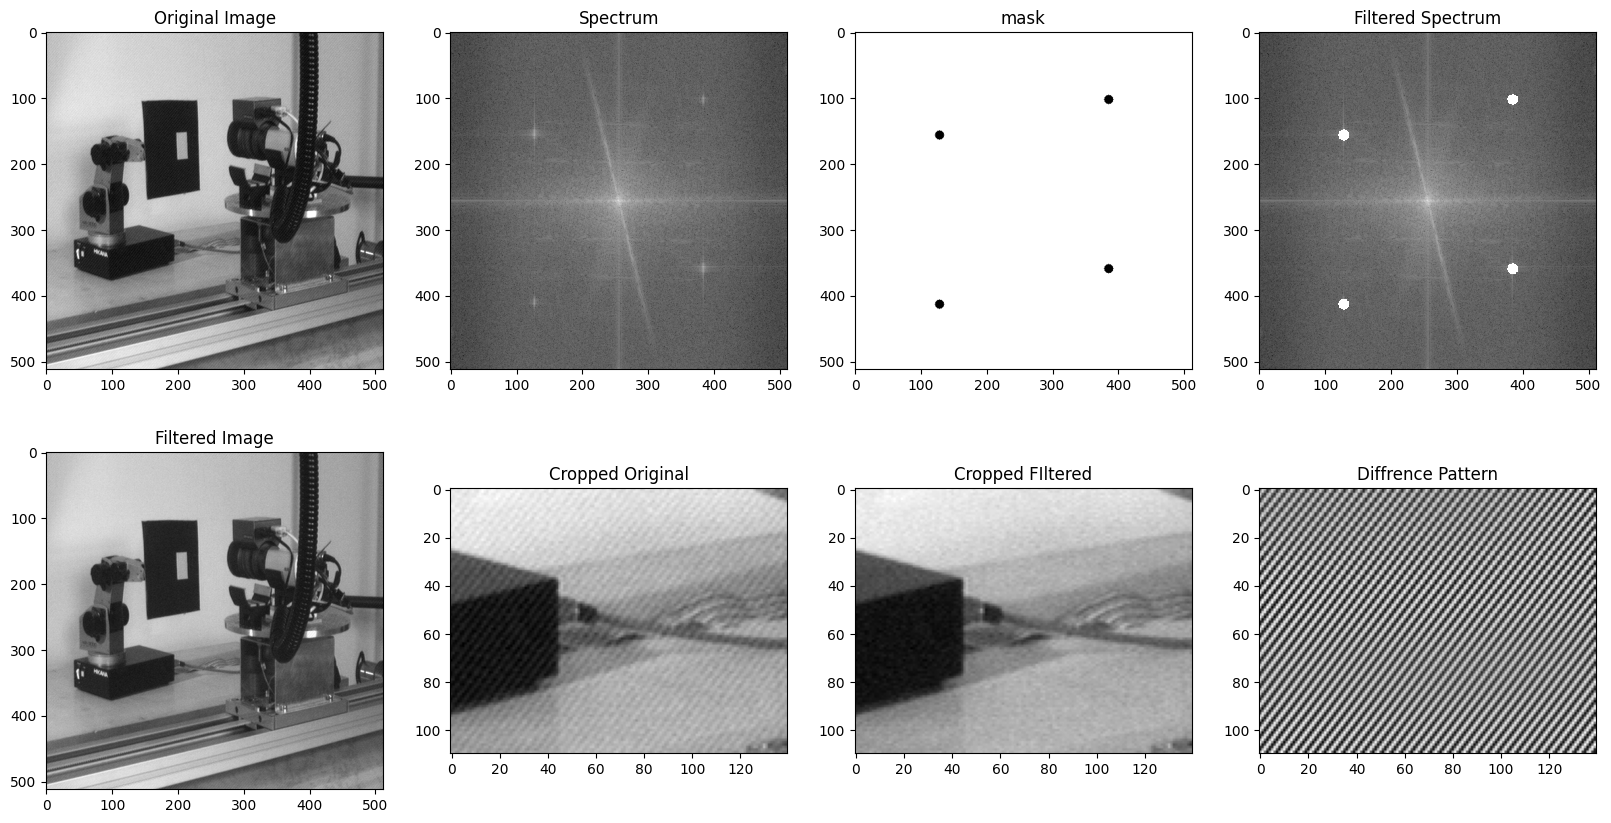

In [140]:
%matplotlib inline
display(Markdown("## Problem 1"))
img = cv2.imread('eye-hand.png', cv2.IMREAD_GRAYSCALE)

np.seterr(all='ignore')
_, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')

F = np.fft.fft2(img)
ax[1].imshow(plot_ff(F), cmap='gray')
ax[1].set_title('Spectrum')

R = 7
mask = np.ones_like(img)
mask = cv2.circle(mask, (385, 102), R, 0, -1)
mask = cv2.circle(mask, (128, 413), R, 0, -1)
mask = cv2.circle(mask, (128, 156), R, 0, -1)
mask = cv2.circle(mask, (385, 359), R, 0, -1)
ax[2].imshow(mask, cmap='gray')
ax[2].set_title('mask')

F_filter = np.fft.fftshift(mask)*F
ax[3].imshow(plot_ff(F_filter), cmap='gray')
ax[3].set_title('Filtered Spectrum')

img_filter = np.abs(np.fft.ifft2(F_filter))
ax[4].imshow(img_filter, cmap='gray')
ax[4].set_title('Filtered Image')

ax[5].imshow(img[270:380, 150:290], cmap='gray')
ax[5].set_title('Cropped Original')

ax[6].imshow(img_filter[270:380, 150:290], cmap='gray')
ax[6].set_title('Cropped FIltered')

ax[7].imshow(img[270:380, 150:290] - img_filter[270:380, 150:290], cmap='gray')
ax[7].set_title('Diffrence Pattern')

plt.show()

## Problem 2

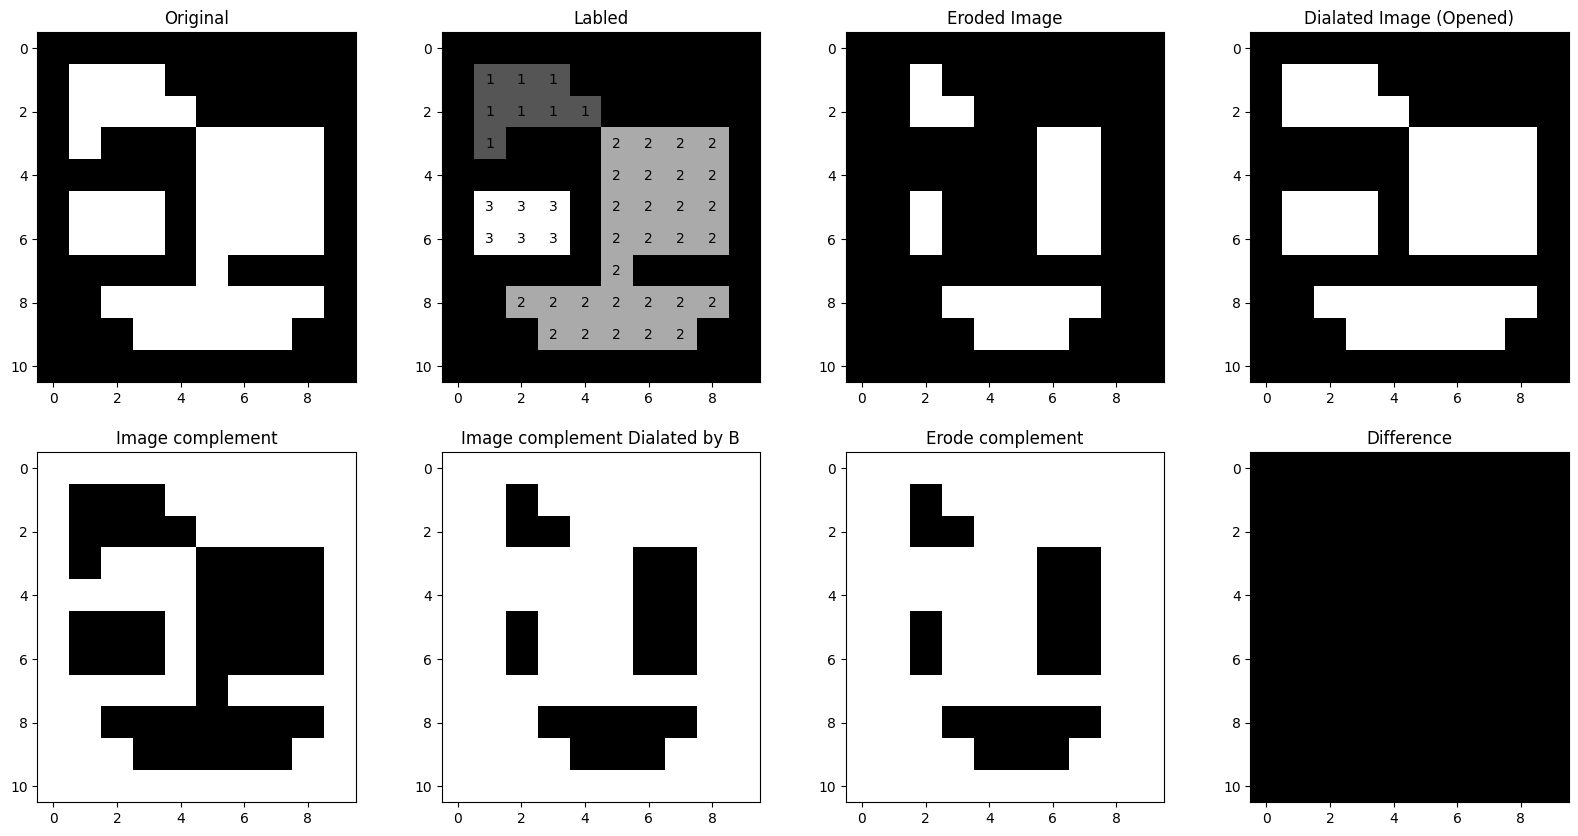

In [141]:
display(Markdown("## Problem 2"))

img = np.array([[0,0,0,0,0,0,0,0,0,0],
                [0,1,1,1,0,0,0,0,0,0],
                [0,1,1,1,1,0,0,0,0,0],
                [0,1,0,0,0,1,1,1,1,0],
                [0,0,0,0,0,1,1,1,1,0],
                [0,1,1,1,0,1,1,1,1,0],
                [0,1,1,1,0,1,1,1,1,0],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,1,1,1,1,1,1,1,0],
                [0,0,0,1,1,1,1,1,0,0],
                [0,0,0,0,0,0,0,0,0,0]], dtype=np.uint8)

_, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()

nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=4)

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(output, cmap='gray')
ax[1].set_title('Labled')
for i in range(0, output.shape[0]):
    for j in range(0, output.shape[1]):
        c = output[i,j]
        ax[1].text(j, i, str(c), va='center', ha='center')

kernel = np.ones((1,3))
erode = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
ax[2].imshow(erode, cmap='gray')
ax[2].set_title('Eroded Image')

open = cv2.morphologyEx(erode, cv2.MORPH_DILATE, kernel)
ax[3].imshow(open, cmap='gray')
ax[3].set_title('Dialated Image (Opened)')

ax[4].imshow(~img, cmap='gray')
ax[4].set_title('Image complement')

dialate = cv2.morphologyEx(~img, cv2.MORPH_DILATE, kernel)
ax[5].imshow(dialate, cmap='gray')
ax[5].set_title('Image complement Dialated by B')

ax[6].imshow(~erode, cmap='gray')
ax[6].set_title('Erode complement')

ax[7].imshow(~erode - dialate, cmap='gray')
ax[7].set_title('Difference')

plt.show()

## Problem 3

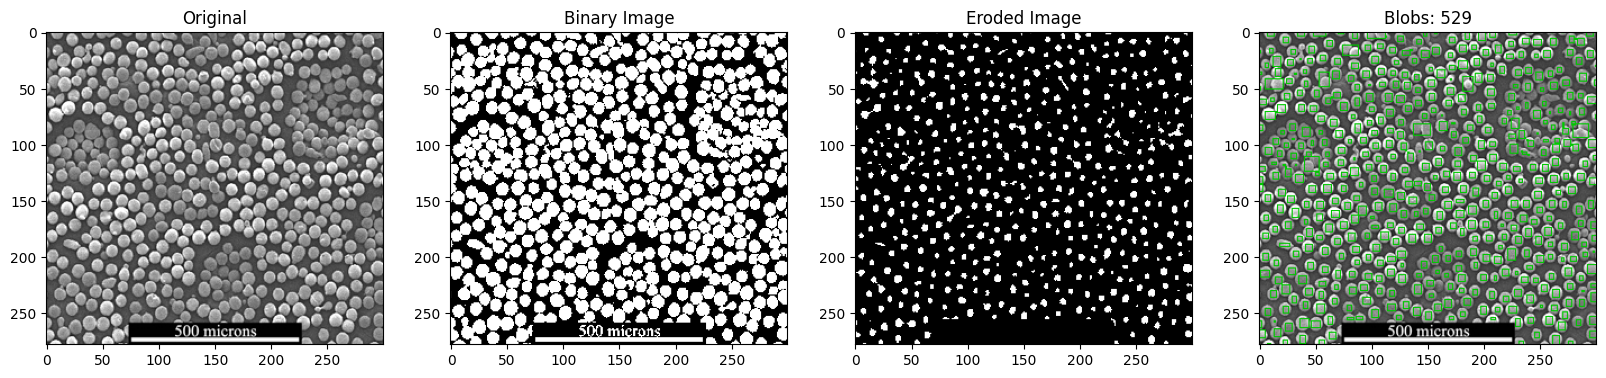

In [142]:
display(Markdown("## Problem 3"))

_, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.flatten()

img = cv2.imread('Particles.jpg', cv2.IMREAD_GRAYSCALE)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')

thresh, im_bw = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
# im_bw = ~im_bw
ax[1].imshow(im_bw, cmap='gray')
ax[1].set_title('Binary Image')

ek = 7
ekernel = np.zeros((ek, ek), dtype=np.uint8)
ekernel = cv2.circle(ekernel, (ek//2, ek//2), ek//2, 1, -1)
erode = cv2.morphologyEx(im_bw, cv2.MORPH_ERODE, ekernel)
ax[2].imshow(erode, cmap='gray')
ax[2].set_title('Eroded Image')

nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(erode, connectivity=4)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
erode = cv2.cvtColor(erode, cv2.COLOR_GRAY2RGB)

for i in range(1, nb_components):
    x, y, w, h = stats[i, 0], stats[i, 1], stats[i, 2], stats[i, 3]
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 200, 0), 1)

ax[3].imshow(img)
ax[3].set_title(f'Blobs: {nb_components - 1}')

plt.show()

## Problem 4

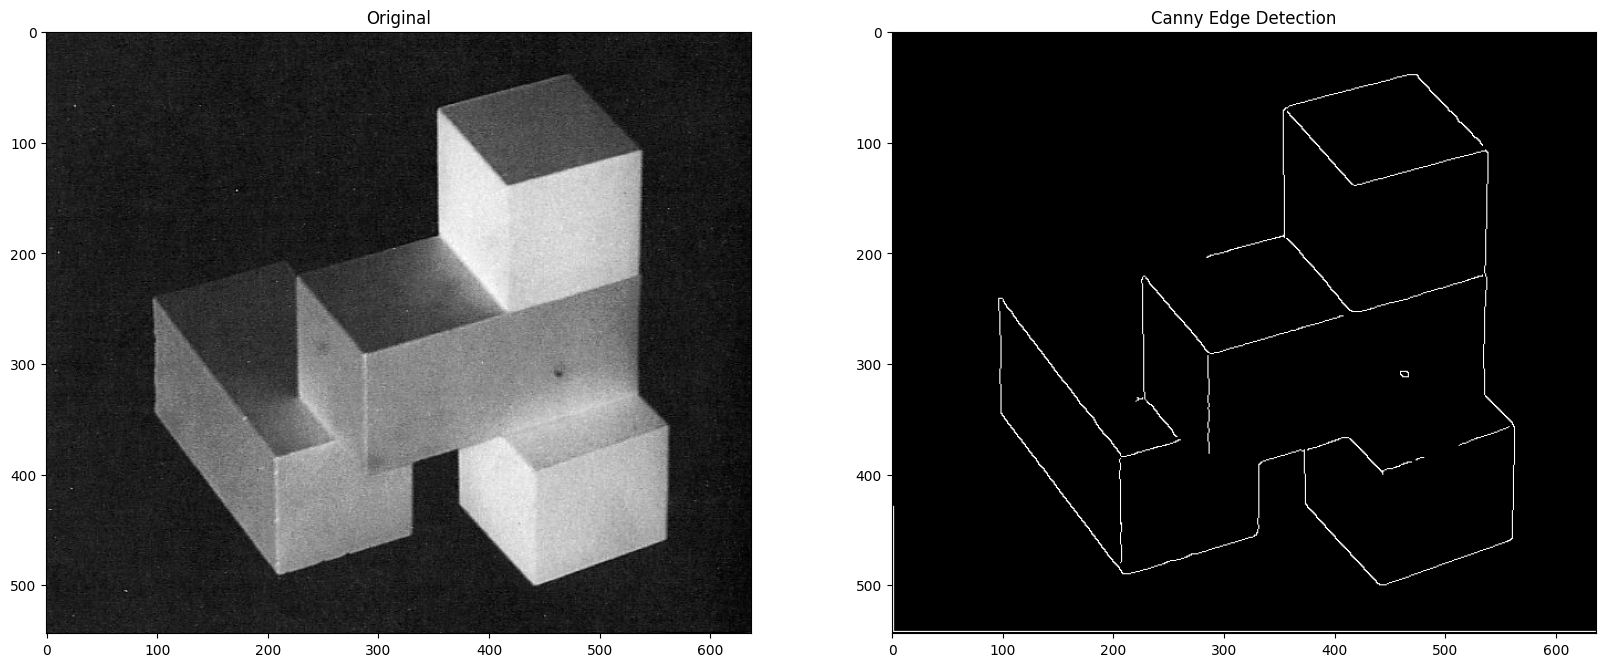

In [143]:
display(Markdown("## Problem 4"))

_, ax = plt.subplots(1, 2, figsize=(20, 10))

img = cv2.imread('Blocks_World_01.jpg', cv2.IMREAD_GRAYSCALE)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')

#apply cannay edge detection
detector = cannyEdgeDetector([img], sigma=2, kernel_size=20, lowthreshold=0.05, highthreshold=0.17, weak_pixel=100)
imgs_final = detector.detect()[0]
ax[1].imshow(imgs_final, cmap='gray')
ax[1].set_title('Canny Edge Detection')

plt.show()

Text(0.5, 1.0, 'Canny Edge Detection')

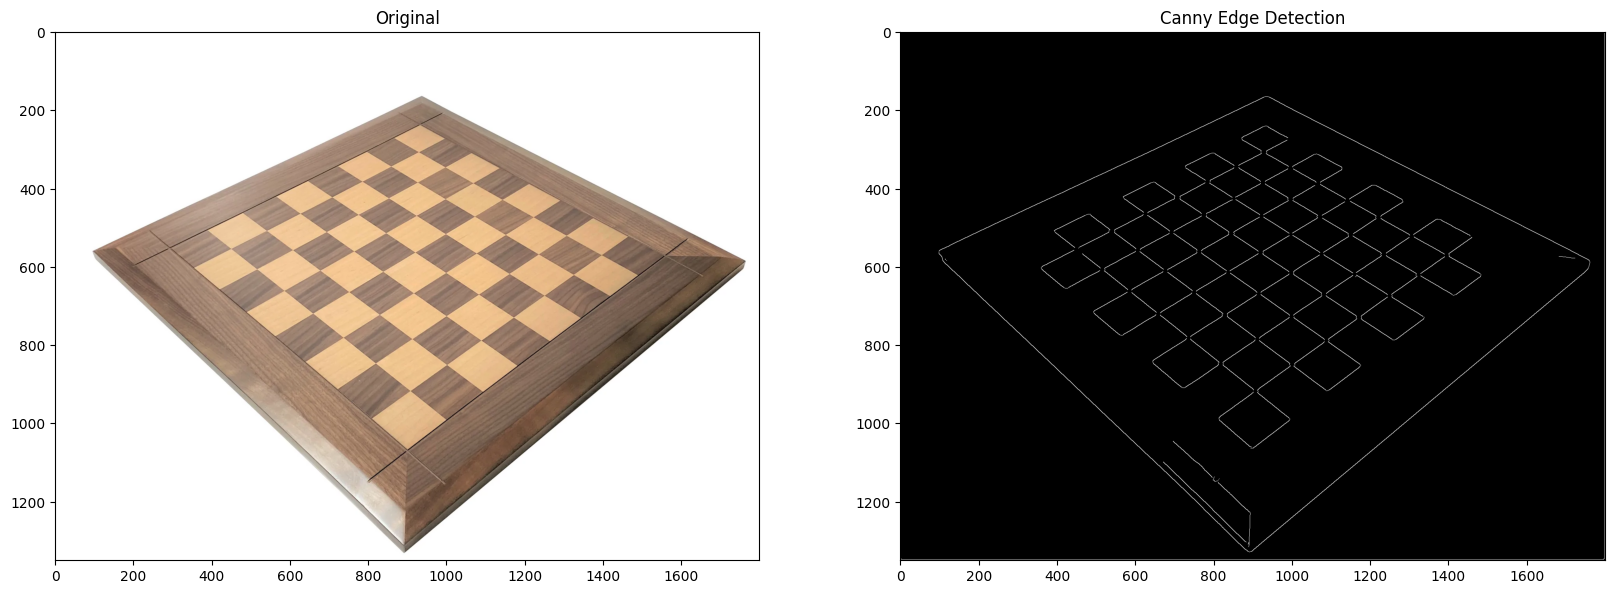

In [151]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = ax.flatten()

img = cv2.imread('asd.webp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[0].imshow(img)
ax[0].set_title('Original')

img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sigma = 5
detector = cannyEdgeDetector([img], sigma=sigma, kernel_size=(sigma * 3) + 1, lowthreshold=0.05, highthreshold=0.22, weak_pixel=100)
imgs_final = detector.detect()[0]
ax[1].imshow(imgs_final, cmap='gray')
ax[1].set_title('Canny Edge Detection')
